In [2]:
#pandas and numpy
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#others
import string
import math
import missingno as msno


In [3]:
#Data visualisation
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
%matplotlib inline

In [4]:
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV,StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [5]:
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

In [6]:
songs_df = pd.read_csv(r'C:\Users\User\Documents\mechine learning models\recommendation\songs.csv')

In [7]:
songs_ex_df = pd.read_csv(r'C:\Users\User\Documents\mechine learning models\recommendation\song_extra_info.csv')
members_df = pd.read_csv(r'C:\Users\User\Documents\mechine learning models\recommendation\members.csv')
train_df = pd.read_csv(r'C:\Users\User\Documents\mechine learning models\recommendation\train.csv',nrows = 100000)

In [8]:
#Now merging the datasets

t_s = pd.merge(train_df,songs_df,on = 'song_id',how='left')
t_s_se = pd.merge(t_s,songs_ex_df,on = 'song_id',how = 'left')
songs = pd.merge(t_s_se,members_df,on = 'msno',how='left')
del songs_df,songs_ex_df,members_df,train_df,t_s,t_s_se

In [9]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [10]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

<AxesSubplot:>

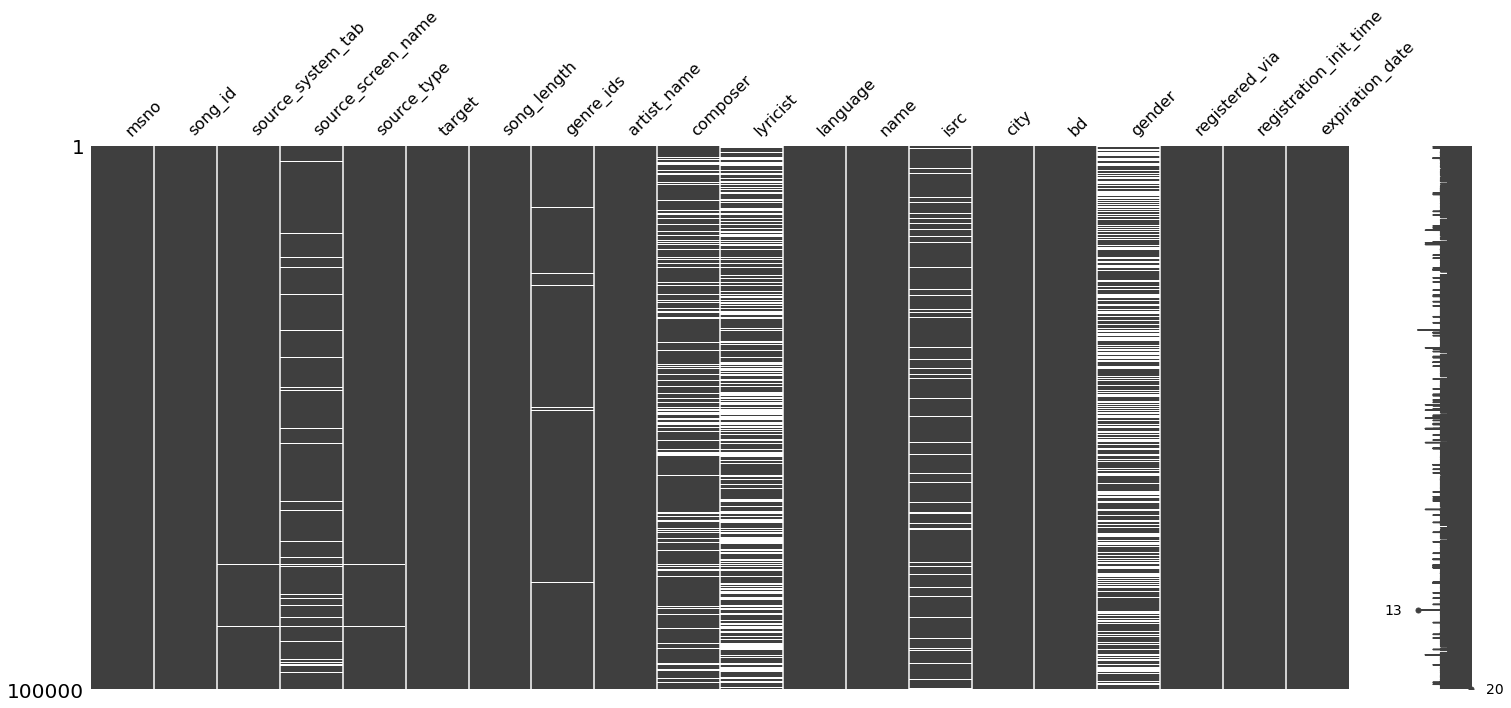

In [11]:
msno.matrix(songs)

In [12]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

In [13]:
#convert string Date time into Python Date time object.
#registration date
songs.registration_init_time= pd.to_datetime(songs.registration_init_time, format='%Y%m%d',errors='ignore')
songs['registration_init_time_year']=songs['registration_init_time'].dt.year
songs['registration_init_time_month']=songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

#expiration_date

songs.expiration_date = pd.to_datetime(songs.expiration_date, format = '%Y%m%d' , errors = 'ignore')

songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiretion_date_day'] =songs['expiration_date'].dt.day


In [14]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiretion_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,unknown,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [15]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

In [16]:
#test and train data
X = songs.drop('target', axis = 1)
y = songs.target
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.25 ,random_state=0)


In [17]:
songs.to_csv('raw_songs.csv', index = False)

In [21]:
def model_with(model_name,xtrain,xtest,ytrain,ytest):
    print("===============================================================")
    print("Modeling with:",model_name)
    print()
    
    if model_name == "Random Forest Classifier":
        model = RandomForestClassifier(n_estimators=1000,)
    elif model_name == "Extra Trees Classifier":
        model = ExtraTreesClassifier(n_estimators=1000,)
    elif model_name == "LightGBM Classifier":
        model = lgbm.LGBMClassifier(n_estimators=1000,)
    elif model_name == "XGBoost Classifier":
        model = xgb.XGBClassifier(n_estimators=1000,)
    elif model_name == "CatBoost Classifier":
        model = cb.CatBoostClassifier(n_estimators=1000,verbose=10)
    else:
        print("Model not found in function.")
    model.fit(xtrain,ytrain)
    test_pre = model.predict(xtest)
    print(classification_report(ytest,test_pre))
    print('RDC: ',roc_auc_score(ytest,test_pre))

models = ['Random Forest Classifier','Extra Trees Classifier','LightGBM Classifier',
        'XGBoost Classifier','CatBoost Classifier']
for i in models:
    model_with(i,xtrain,xtest,ytrain,ytest)




Modeling with: Random Forest Classifier

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      6176
           1       0.87      0.94      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.81      0.75      0.78     25000
weighted avg       0.84      0.85      0.84     25000

RDC:  0.7535436310497678
Modeling with: Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.74      0.60      0.66      6176
           1       0.88      0.93      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.81      0.76      0.78     25000
weighted avg       0.84      0.85      0.84     25000

RDC:  0.7630466783667196
Modeling with: LightGBM Classifier

              precision    recall  f1-score   support

           0       0.75      0.53      0.63      6176
           1       0.86      0.94      0.90     18824

    accuracy    

In [ ]:
model = RandomForestClassifier(n_estimators=1000,)
model.fit(xtrain,ytrain )

In [ ]:
val_pred = model.predict(xtest)

In [ ]:

print(classification_report(ytest,val_pred))
print()
print("Accuracy :",accuracy_score(ytest,val_pred))
print("===================================================================")
print()